In [23]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from functools import partial
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
data = pd.read_excel('data v2.xlsx')

In [6]:
df = data.iloc[:, 1:]

df.head()

,wk 1,wk 2,wk 3,wk 4,wk 5,wk 6,wk 7,wk 8,wk 9,wk 10,...,wk 53,wk 54,wk 55,wk 56,wk 57,wk 58,wk 59,wk 60,wk 61,wk 62
0,72848.0,57156.0,1099.0,71916.0,31700.0,65996.0,58028.0,60564.0,52239.0,24323.0,...,39966.0,41614.0,38862.0,14572.0,15601.0,8917.0,9358.0,24340.0,21677.0,19287.0
1,8067.0,9288.0,4099.0,8258.0,5709.0,10616.0,5009.0,6197.0,7866.0,9278.0,...,13640.0,11163.0,14303.0,8431.0,8099.0,4668.0,2701.0,4380.0,6482.0,8623.0
2,2914.0,7470.0,NaN,1202.0,12490.0,12119.0,14724.0,6245.0,1093.0,12820.0,...,5944.0,4720.0,4810.0,2805.0,2037.0,1754.0,2054.0,3074.0,4556.0,6626.0
3,138572.0,198611.0,96669.0,22963.0,104178.0,125459.0,132591.0,100540.0,161350.0,218670.0,...,116880.0,107120.0,93911.0,100258.0,1952778.0,1033274.0,1310199.0,1478926.0,2129291.0,1893435.0
4,9244.0,11096.0,9232.0,8208.0,7600.0,6944.0,4563.0,9776.0,8700.0,11534.0,...,4989.0,4932.0,5125.0,5017.0,33613.0,15980.0,20172.0,27206.0,33821.0,24743.0


In [7]:
def has_nulls(dataset):
    print("Dataset has nulls is ", dataset.isnull().values.any())

has_nulls(df)

Dataset has nulls is  True


In [8]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
imputer.fit(df)
df = pd.DataFrame(imputer.transform(df))

has_nulls(df)

Dataset has nulls is  False


In [9]:
def remove_outliers_zscore(sales_data, z_threshold=3):
    z_scores = np.abs(stats.zscore(sales_data))
    sales_data_no_outliers = sales_data[(z_scores < z_threshold).all(axis=1)]
    return sales_data_no_outliers

In [10]:
sales_data = df

sales_data_no_outliers = remove_outliers_zscore(sales_data)
print(sales_data_no_outliers.shape)

(15434, 62)


In [11]:
# To Convert annual
weight_column1 = 0.7
weight_column2 = 0.3

for i in range(0, 10):
    sales_data_no_outliers[i] = sales_data_no_outliers[i] * weight_column1 + sales_data_no_outliers[i+52] * weight_column2

In [12]:
sales_data_no_outliers.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,62983.4,52493.4,12427.9,54712.8,26870.3,48872.3,43427.0,49696.8,43070.4,22812.2,...,39966.0,41614.0,38862.0,14572.0,15601.0,8917.0,9358.0,24340.0,21677.0,19287.0
1,9738.9,9850.5,7160.2,8309.9,6426.0,8831.6,4316.6,5651.9,7450.8,9081.5,...,13640.0,11163.0,14303.0,8431.0,8099.0,4668.0,2701.0,4380.0,6482.0,8623.0
2,3823.0,6645.0,3158.0,1682.9,9354.1,9009.5,10923.0,5293.7,2131.9,10961.8,...,5944.0,4720.0,4810.0,2805.0,2037.0,1754.0,2054.0,3074.0,4556.0,6626.0
4,7967.5,9246.8,7999.9,7250.7,15403.9,9654.8,9245.7,15005.0,16236.3,15496.7,...,4989.0,4932.0,5125.0,5017.0,33613.0,15980.0,20172.0,27206.0,33821.0,24743.0
5,39479.0,55438.6,39854.3,35344.0,71615.6,56102.9,54335.0,45431.5,41073.8,41185.7,...,35244.0,30758.0,31273.0,27630.0,152460.0,95613.0,103174.0,79931.0,73285.0,82744.0


In [13]:
annual_data = sales_data_no_outliers.drop(columns=range(52,62))

In [14]:
annual_data.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,62983.4,52493.4,12427.9,54712.8,26870.3,48872.3,43427.0,49696.8,43070.4,22812.2,...,65689.0,27310.0,28338.0,26669.0,43789.0,24282.0,53120.0,40401.0,31224.0,57982.0
1,9738.9,9850.5,7160.2,8309.9,6426.0,8831.6,4316.6,5651.9,7450.8,9081.5,...,22970.0,11753.0,18398.0,14626.0,16863.0,17231.0,15723.0,13696.0,12411.0,16156.0
2,3823.0,6645.0,3158.0,1682.9,9354.1,9009.5,10923.0,5293.7,2131.9,10961.8,...,4708.0,4674.0,4548.0,4386.0,4743.0,5379.0,6069.0,5402.0,6422.0,6444.0
4,7967.5,9246.8,7999.9,7250.7,15403.9,9654.8,9245.7,15005.0,16236.3,15496.7,...,8776.0,5497.0,7344.0,6591.0,6244.0,6495.0,6428.0,4725.0,4626.0,6037.0
5,39479.0,55438.6,39854.3,35344.0,71615.6,56102.9,54335.0,45431.5,41073.8,41185.7,...,45469.0,14360.0,24682.0,27983.0,29493.0,31042.0,32299.0,32459.0,30806.0,38095.0


In [15]:
annual_data.shape

(15434, 52)

In [16]:
annual_data.idxmax(axis = 1)

0        42
1        10
2        10
4        17
5        41
         ..
15785    15
15786     9
15787    17
15788     8
15789    22
Length: 15434, dtype: int64

In [17]:
max_sales_week = annual_data.idxmax(axis=1)

def determine_season(week_num):
    if week_num in range(0, 13):
        return "Season_1"
    elif week_num in range(13, 26):
        return "Season_2"
    elif week_num in range(26, 39):
        return "Season_3"
    else:
        return "Season_4"

seasons = max_sales_week.apply(determine_season)

seasons_df = pd.concat([max_sales_week, seasons], axis=1)
seasons_df.columns = ['Week_with_Max_Sale', 'Season']

print(seasons_df.Season.value_counts())

Season
Season_2    6507
Season_1    5849
Season_4    1881
Season_3    1197
Name: count, dtype: int64


In [18]:
scaler = MinMaxScaler()
normalized_sales_data = scaler.fit_transform(annual_data.T).T

normalized_sales_data_df = pd.DataFrame(normalized_sales_data, index=annual_data.index, columns=annual_data.columns)

In [19]:
normalized_sales_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.957762,0.793999,0.168523,0.828647,0.393988,0.737469,0.652460,0.750340,0.646893,0.330636,...,1.000000,0.400852,0.416901,0.390846,0.658112,0.353581,0.803781,0.605220,0.461955,0.879683
1,0.277461,0.281494,0.184273,0.225820,0.157741,0.244673,0.081512,0.129767,0.194775,0.253704,...,0.755601,0.350246,0.590380,0.454069,0.534909,0.548208,0.493712,0.420461,0.374024,0.509360
2,0.233801,0.467933,0.178628,0.056243,0.692699,0.664109,0.822866,0.355820,0.093495,0.826085,...,0.307226,0.304406,0.293952,0.280511,0.310130,0.362897,0.420144,0.364805,0.449432,0.451257
4,0.268060,0.345011,0.270009,0.224944,0.715362,0.369552,0.344944,0.691368,0.765432,0.720944,...,0.316692,0.119459,0.230556,0.185263,0.164391,0.179489,0.175459,0.073023,0.067068,0.151940
5,0.332631,0.543972,0.337601,0.277875,0.758192,0.552769,0.529358,0.411456,0.353750,0.355232,...,0.411952,0.000000,0.136686,0.180399,0.200395,0.220907,0.237552,0.239671,0.217782,0.314304


# Agglomerative Clustering

In [22]:
sales_data_normalized = normalized_sales_data_df

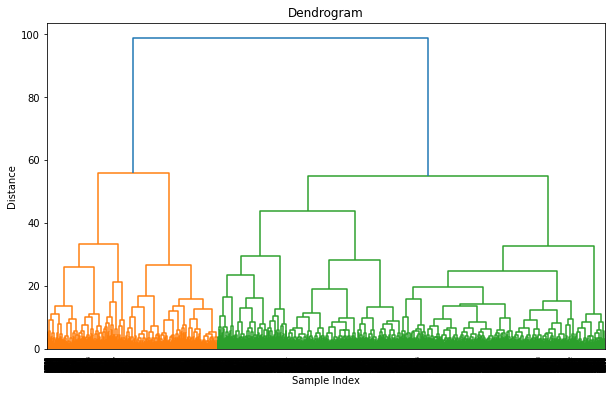

In [23]:
linked = linkage(sales_data_normalized, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.show()

num_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
sales_data_normalized['cluster'] = agg_clustering.fit_predict(sales_data_normalized)

def assign_trend_label(cluster_data):
    if cluster_data['cluster'].mean() > 0.5:
        return "Emerging"
    elif cluster_data['cluster'].mean() < -0.5:
        return "Declining"
    else:
        return "Saturated"

cluster_trends_df = sales_data_normalized.groupby('cluster').apply(assign_trend_label)
cluster_trends_df = cluster_trends_df.reset_index()
cluster_trends_df.columns = ['cluster', 'trend']

#print(cluster_trends_df)
#print(sales_data_normalized['cluster'].value_counts())


In [24]:
print(cluster_trends_df)

   cluster      trend
0        0  Saturated
1        1   Emerging
2        2   Emerging


In [25]:
print(sales_data_normalized['cluster'].value_counts())

cluster
0    10702
2     2566
1     2166
Name: count, dtype: int64


# Kmeans and sub clustering

In [19]:
sales_data_normalized = normalized_sales_data_df

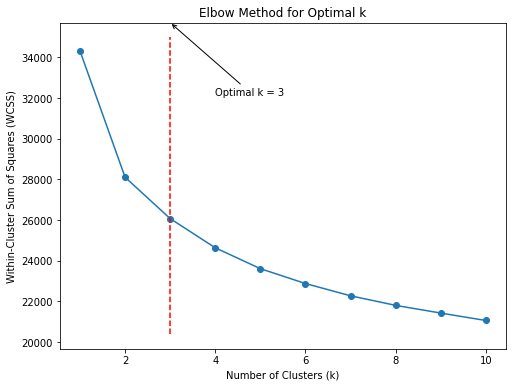

Optimal number of clusters: 3


In [20]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from kneed import KneeLocator

X = sales_data_normalized
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

knee = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.vlines(knee.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.annotate(f'Optimal k = {knee.elbow}', xy=(knee.elbow, plt.ylim()[1]), xytext=(knee.elbow + 1, plt.ylim()[1] * 0.9),
             arrowprops=dict(arrowstyle='->'))
plt.show()

optimal_k = knee.elbow
print("Optimal number of clusters:", optimal_k)

In [21]:
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
sales_data_normalized['cluster'] = kmeans.fit_predict(sales_data_normalized)

In [22]:
def assign_trend_label(cluster_data):
    if cluster_data['cluster'].mean() > 0.5:
        return "Emerging"
    elif cluster_data['cluster'].mean() < -0.5:
        return "Declining"
    else:
        return "Saturated"

In [23]:
cluster_trends_df = sales_data_normalized.groupby('cluster').apply(assign_trend_label)
cluster_trends_df = cluster_trends_df.reset_index()
cluster_trends_df.columns = ['cluster', 'trend']

print(cluster_trends_df)

   cluster      trend
0        0  Saturated
1        1   Emerging
2        2   Emerging


In [24]:
sales_data_normalized['cluster'].value_counts()

cluster
0    6256
2    5464
1    3714
Name: count, dtype: int64

In [25]:
sales_data_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,cluster
0,0.957762,0.793999,0.168523,0.828647,0.393988,0.737469,0.652460,0.750340,0.646893,0.330636,...,0.400852,0.416901,0.390846,0.658112,0.353581,0.803781,0.605220,0.461955,0.879683,0
1,0.277461,0.281494,0.184273,0.225820,0.157741,0.244673,0.081512,0.129767,0.194775,0.253704,...,0.350246,0.590380,0.454069,0.534909,0.548208,0.493712,0.420461,0.374024,0.509360,1
2,0.233801,0.467933,0.178628,0.056243,0.692699,0.664109,0.822866,0.355820,0.093495,0.826085,...,0.304406,0.293952,0.280511,0.310130,0.362897,0.420144,0.364805,0.449432,0.451257,0
4,0.268060,0.345011,0.270009,0.224944,0.715362,0.369552,0.344944,0.691368,0.765432,0.720944,...,0.119459,0.230556,0.185263,0.164391,0.179489,0.175459,0.073023,0.067068,0.151940,0
5,0.332631,0.543972,0.337601,0.277875,0.758192,0.552769,0.529358,0.411456,0.353750,0.355232,...,0.000000,0.136686,0.180399,0.200395,0.220907,0.237552,0.239671,0.217782,0.314304,1


In [26]:
sales_data_normalized['trend'] = np.where( sales_data_normalized.cluster == 0, "Saturated", "Emerging" )
sales_data_normalized.head(10)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,cluster,trend
0,0.957762,0.793999,0.168523,0.828647,0.393988,0.737469,0.652460,0.750340,0.646893,0.330636,...,0.416901,0.390846,0.658112,0.353581,0.803781,0.605220,0.461955,0.879683,0,Saturated
1,0.277461,0.281494,0.184273,0.225820,0.157741,0.244673,0.081512,0.129767,0.194775,0.253704,...,0.590380,0.454069,0.534909,0.548208,0.493712,0.420461,0.374024,0.509360,1,Emerging
2,0.233801,0.467933,0.178628,0.056243,0.692699,0.664109,0.822866,0.355820,0.093495,0.826085,...,0.293952,0.280511,0.310130,0.362897,0.420144,0.364805,0.449432,0.451257,0,Saturated
4,0.268060,0.345011,0.270009,0.224944,0.715362,0.369552,0.344944,0.691368,0.765432,0.720944,...,0.230556,0.185263,0.164391,0.179489,0.175459,0.073023,0.067068,0.151940,0,Saturated
5,0.332631,0.543972,0.337601,0.277875,0.758192,0.552769,0.529358,0.411456,0.353750,0.355232,...,0.136686,0.180399,0.200395,0.220907,0.237552,0.239671,0.217782,0.314304,1,Emerging
6,0.350548,0.385896,0.321126,0.115624,0.779156,0.353988,0.693025,0.644904,0.621091,0.600801,...,0.200778,0.209733,0.184753,0.154236,0.161306,0.124897,0.121362,0.150112,0,Saturated
7,0.524332,0.830793,0.373104,0.342543,1.000000,0.755398,0.815982,0.903074,0.814763,0.963912,...,0.629545,0.693663,0.720709,0.499019,0.460833,0.736677,0.727331,0.670207,2,Emerging
8,0.099327,0.098301,0.077213,0.064973,0.129408,0.128621,0.134726,0.125396,0.139028,0.139642,...,0.073689,0.100282,0.096804,0.099590,0.081583,0.068692,0.060426,0.062425,1,Emerging
9,0.238740,0.386167,0.399822,0.348024,1.000000,0.660223,0.915614,0.806299,0.620135,0.721766,...,0.379644,0.345375,0.433677,0.432783,0.397725,0.426528,0.351577,0.351945,1,Emerging
10,0.418726,0.484410,0.356492,0.050669,0.648513,0.741246,0.318048,1.000000,0.656777,0.551542,...,0.355682,0.245996,0.224911,0.230448,0.237690,0.197862,0.193176,0.174859,0,Saturated


In [27]:
sales_data_normalized.shape

(15434, 54)

In [28]:
seasons_df.head()

,Week_with_Max_Sale,Season
0,42,Season_4
1,10,Season_1
2,10,Season_1
4,17,Season_2
5,41,Season_4


In [29]:
sales_data_normalized['season'] = seasons_df['Season']

In [30]:
sales_data_normalized

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,cluster,trend,season
0,0.957762,0.793999,0.168523,0.828647,0.393988,0.737469,0.652460,0.750340,0.646893,0.330636,...,0.390846,0.658112,0.353581,0.803781,0.605220,0.461955,0.879683,0,Saturated,Season_4
1,0.277461,0.281494,0.184273,0.225820,0.157741,0.244673,0.081512,0.129767,0.194775,0.253704,...,0.454069,0.534909,0.548208,0.493712,0.420461,0.374024,0.509360,1,Emerging,Season_1
2,0.233801,0.467933,0.178628,0.056243,0.692699,0.664109,0.822866,0.355820,0.093495,0.826085,...,0.280511,0.310130,0.362897,0.420144,0.364805,0.449432,0.451257,0,Saturated,Season_1
4,0.268060,0.345011,0.270009,0.224944,0.715362,0.369552,0.344944,0.691368,0.765432,0.720944,...,0.185263,0.164391,0.179489,0.175459,0.073023,0.067068,0.151940,0,Saturated,Season_2
5,0.332631,0.543972,0.337601,0.277875,0.758192,0.552769,0.529358,0.411456,0.353750,0.355232,...,0.180399,0.200395,0.220907,0.237552,0.239671,0.217782,0.314304,1,Emerging,Season_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15785,0.338063,0.243196,0.393400,0.313209,0.586813,0.484504,0.653945,0.654433,0.957482,0.983200,...,0.162810,0.160417,0.162544,0.126285,0.076241,0.118972,0.151418,0,Saturated,Season_2
15786,0.195760,0.198230,0.214665,0.356250,0.250733,0.211656,0.448680,0.172363,0.878184,1.000000,...,0.087025,0.082364,0.122639,0.088509,0.073024,0.067051,0.095052,0,Saturated,Season_1
15787,0.152925,0.144623,0.166365,0.570562,0.754151,0.426792,0.655684,0.442731,0.601546,0.188293,...,0.146455,0.155850,0.184302,0.129131,0.105144,0.112473,0.160048,0,Saturated,Season_2
15788,0.199013,0.322564,0.304112,0.357265,0.961326,0.627435,0.680922,0.886253,1.000000,0.836059,...,0.271721,0.266296,0.248555,0.206329,0.401111,0.315046,0.345286,0,Saturated,Season_1


In [31]:
data2 = sales_data_normalized[['trend', 'season']]
df = pd.DataFrame(data2)
combinations_present = df.groupby(['trend', 'season']).size().reset_index()
print(combinations_present)

       trend    season     0
0   Emerging  Season_1  3039
1   Emerging  Season_2  3267
2   Emerging  Season_3  1092
3   Emerging  Season_4  1780
4  Saturated  Season_1  2810
5  Saturated  Season_2  3240
6  Saturated  Season_3   105
7  Saturated  Season_4   101


In [34]:
transposed_df = sales_data_normalized.iloc[:, :-3].T
transposed_df.head()

,0,1,2,4,5,6,7,8,9,10,...,15780,15781,15782,15783,15784,15785,15786,15787,15788,15789
0,0.957762,0.277461,0.233801,0.268060,0.332631,0.350548,0.524332,0.099327,0.238740,0.418726,...,0.344141,0.119481,0.163515,0.402610,0.277620,0.338063,0.195760,0.152925,0.199013,0.602960
1,0.793999,0.281494,0.467933,0.345011,0.543972,0.385896,0.830793,0.098301,0.386167,0.484410,...,0.230993,0.260748,0.475640,0.397668,0.282249,0.243196,0.198230,0.144623,0.322564,0.380885
2,0.168523,0.184273,0.178628,0.270009,0.337601,0.321126,0.373104,0.077213,0.399822,0.356492,...,0.337592,0.093246,0.152867,0.294155,0.309624,0.393400,0.214665,0.166365,0.304112,0.507549
3,0.828647,0.225820,0.056243,0.224944,0.277875,0.115624,0.342543,0.064973,0.348024,0.050669,...,0.310753,0.217952,0.441331,0.333043,0.361901,0.313209,0.356250,0.570562,0.357265,0.506263
4,0.393988,0.157741,0.692699,0.715362,0.758192,0.779156,1.000000,0.129408,1.000000,0.648513,...,1.000000,1.000000,0.965536,1.000000,0.713518,0.586813,0.250733,0.754151,0.961326,0.544571


In [44]:
sales_data_normalized.loc[(sales_data_normalized['trend'] == "Emerging") & (sales_data_normalized['season'] == "Season_1")].index

Index([    1,     7,     9,    15,    17,    22,    33,    36,    37,    40,
       ...
       15732, 15749, 15756, 15760, 15761, 15763, 15770, 15772, 15775, 15783],
      dtype='int64', length=3039)

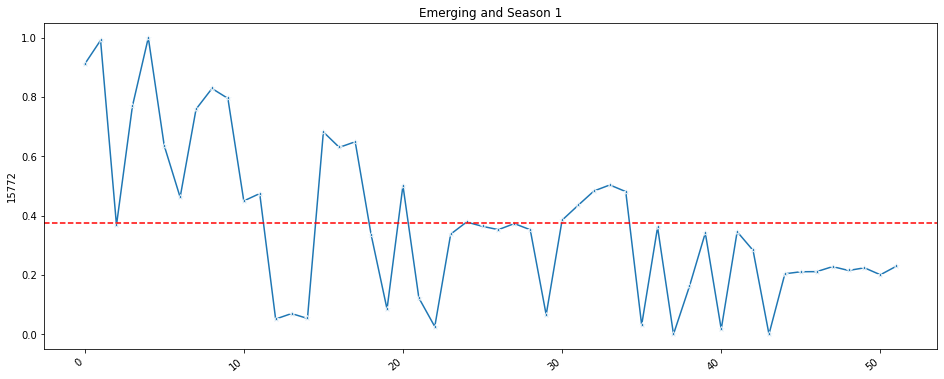

In [55]:
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index,y=transposed_df[15772],marker='*',ax = ax)
ax.axhline(transposed_df[15772].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Emerging and Season 1")
plt.show()

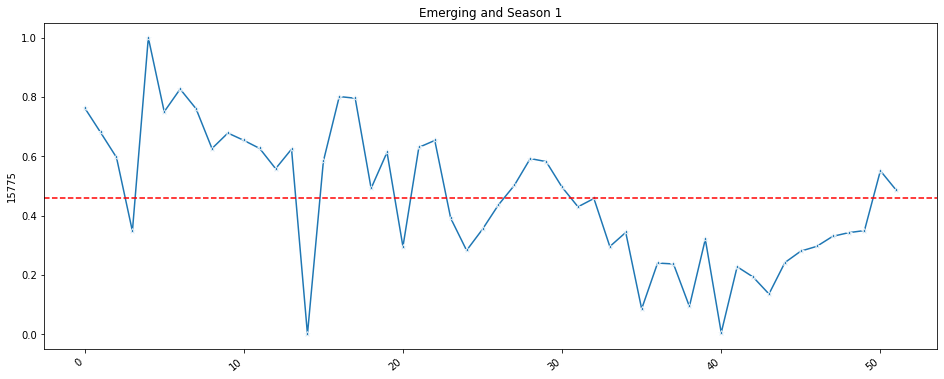

In [54]:
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index,y=transposed_df[15775],marker='*',ax = ax)
ax.axhline(transposed_df[15775].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Emerging and Season 1")
plt.show()

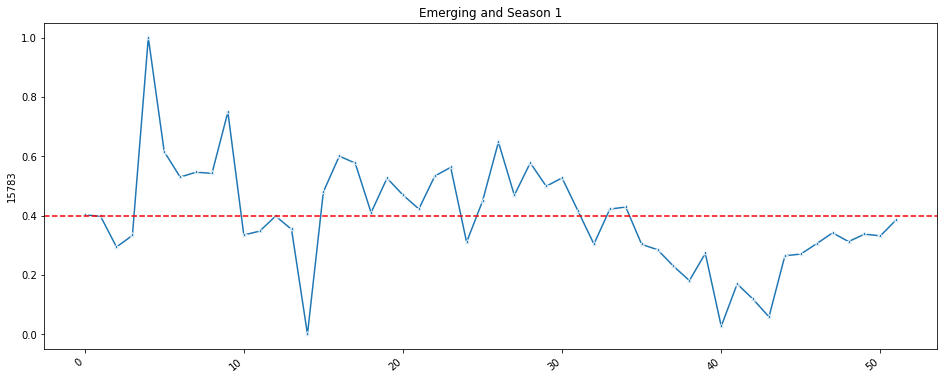

In [53]:
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index,y=transposed_df[15783],marker='*',ax = ax)
ax.axhline(transposed_df[15783].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Emerging and Season 1")
plt.show()

In [50]:
sales_data_normalized.loc[(sales_data_normalized['trend'] == "Emerging") & (sales_data_normalized['season'] == "Season_2")].index

Index([    8,    11,    13,    14,    31,    34,    35,    41,    46,    47,
       ...
       15755, 15757, 15762, 15765, 15768, 15771, 15777, 15778, 15782, 15789],
      dtype='int64', length=3267)

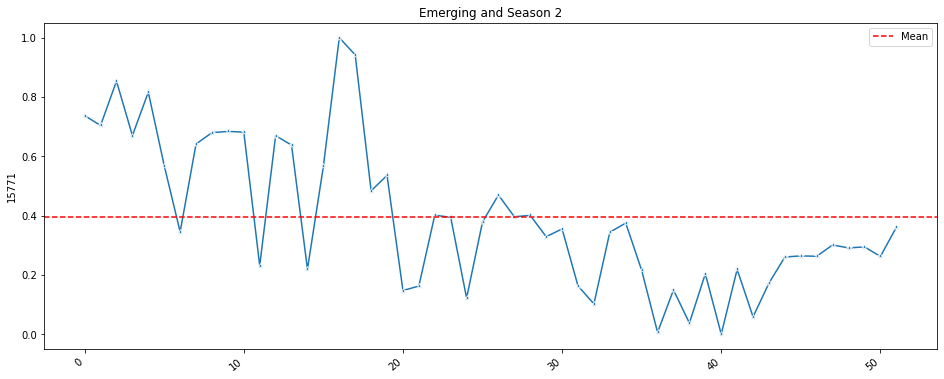

In [52]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index, y=transposed_df[15771], marker='*', ax=ax)
ax.axhline(transposed_df[15771].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Emerging and Season 2")
plt.legend()
plt.show()

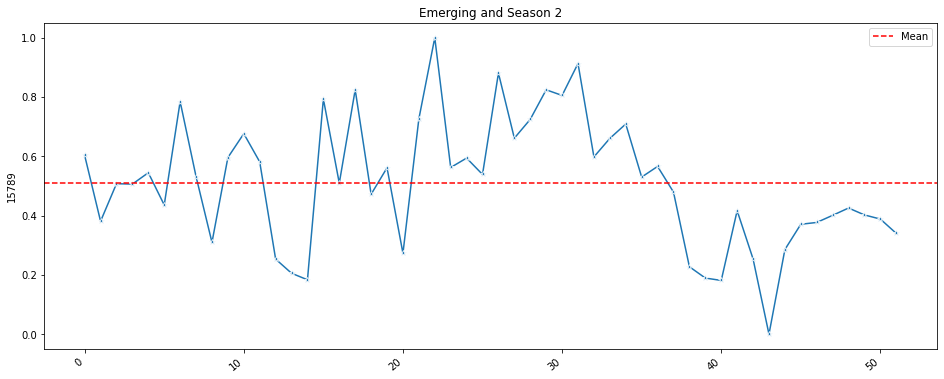

In [56]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index, y=transposed_df[15789], marker='*', ax=ax)
ax.axhline(transposed_df[15789].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Emerging and Season 2")
plt.legend()
plt.show()

In [58]:
sales_data_normalized.loc[(sales_data_normalized['trend'] == "Saturated") & (sales_data_normalized['season'] == "Season_3")].index

Index([  125,   193,   381,   477,   481,   567,   607,   723,   778,   830,
       ...
       13594, 13876, 14554, 14668, 14724, 14834, 14835, 14960, 15138, 15447],
      dtype='int64', length=105)

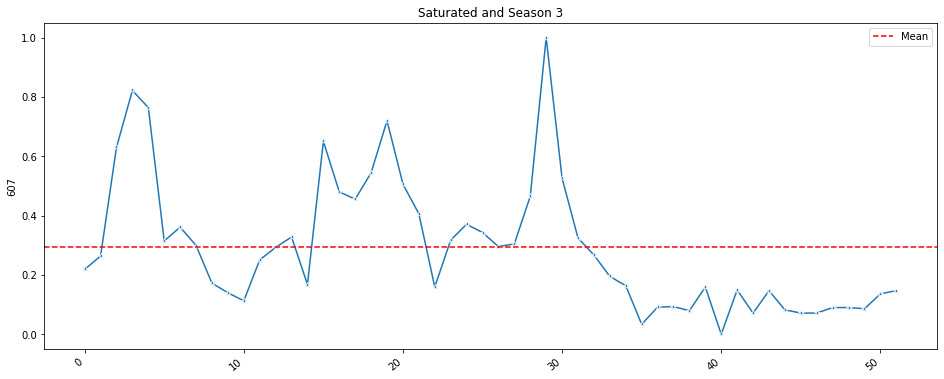

In [60]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index, y=transposed_df[607], marker='*', ax=ax)
ax.axhline(transposed_df[607].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Saturated and Season 3")
plt.legend()
plt.show()

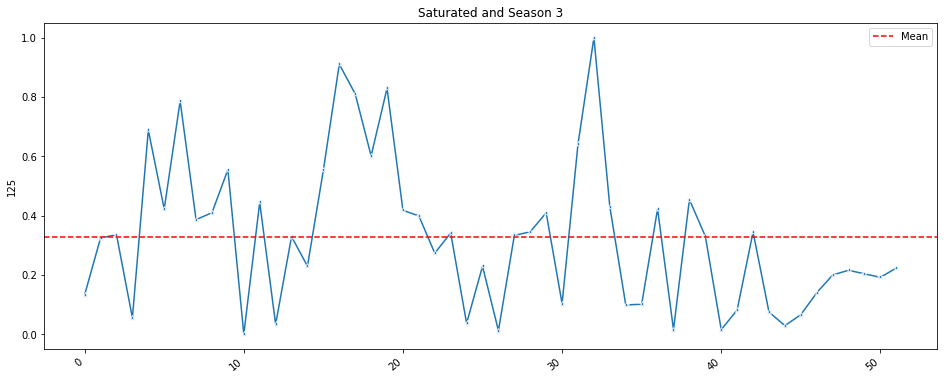

In [61]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=transposed_df.index, y=transposed_df[125], marker='*', ax=ax)
ax.axhline(transposed_df[125].mean(), color='red', linestyle='--', label='Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Saturated and Season 3")
plt.legend()
plt.show()

# Best model of all

# Features = 6 months, 1 year growth, mean and overall sales - KMEANS

In [102]:
scaler = MinMaxScaler()
normalized_sales_data = scaler.fit_transform(annual_data.T).T

normalized_sales_data_df = pd.DataFrame(normalized_sales_data, index=annual_data.index, columns=annual_data.columns)

In [103]:
normalized_sales_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.957762,0.793999,0.168523,0.828647,0.393988,0.737469,0.652460,0.750340,0.646893,0.330636,...,1.000000,0.400852,0.416901,0.390846,0.658112,0.353581,0.803781,0.605220,0.461955,0.879683
1,0.277461,0.281494,0.184273,0.225820,0.157741,0.244673,0.081512,0.129767,0.194775,0.253704,...,0.755601,0.350246,0.590380,0.454069,0.534909,0.548208,0.493712,0.420461,0.374024,0.509360
2,0.233801,0.467933,0.178628,0.056243,0.692699,0.664109,0.822866,0.355820,0.093495,0.826085,...,0.307226,0.304406,0.293952,0.280511,0.310130,0.362897,0.420144,0.364805,0.449432,0.451257
4,0.268060,0.345011,0.270009,0.224944,0.715362,0.369552,0.344944,0.691368,0.765432,0.720944,...,0.316692,0.119459,0.230556,0.185263,0.164391,0.179489,0.175459,0.073023,0.067068,0.151940
5,0.332631,0.543972,0.337601,0.277875,0.758192,0.552769,0.529358,0.411456,0.353750,0.355232,...,0.411952,0.000000,0.136686,0.180399,0.200395,0.220907,0.237552,0.239671,0.217782,0.314304


In [104]:
def get_6_months_growth(df):
    sum = 0
    for i in range(0, 25):
        sum += (df[i+1] - df[i])
    return sum

In [105]:
def get_12_months_growth(df):
    sum = 0
    for i in range(0, 51):
        sum += (df[i+1] - df[i])
    return sum

In [106]:
get_6_months_growth(annual_data)

0       -56096.4
1        -7310.9
2        -2818.0
4         2576.5
5       -12029.0
          ...   
15785    -2939.7
15786      596.4
15787     2281.9
15788      244.6
15789     -988.8
Length: 15434, dtype: float64

In [107]:
annual_data.mean(axis = 1)

0        24341.548077
1         9617.613462
2         4775.844231
4         9119.890385
5        35538.911538
             ...     
15785     8838.826923
15786    18856.655769
15787     6846.286538
15788    13941.463462
15789     8893.501923
Length: 15434, dtype: float64

In [108]:
features = pd.DataFrame()
features['6_months'] = get_6_months_growth(annual_data)
features['12_months'] = get_12_months_growth(annual_data)
features['volume'] = annual_data.mean(axis = 1)
features['sales'] = annual_data.sum(axis = 1)
features.head()

,6_months,12_months,volume,sales
0,-56096.4,-5001.4,24341.548077,1265760.5
1,-7310.9,6417.1,9617.613462,500115.9
2,-2818.0,2621.0,4775.844231,248343.9
4,2576.5,-1930.5,9119.890385,474234.3
5,-12029.0,-1384.0,35538.911538,1848023.4


In [109]:
X = features.values
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X.T).T
scaled_df

array([[-0.65569173, -0.56348641, -0.51053454,  1.72971267],
       [-0.62454173, -0.56080655, -0.54594748,  1.73129576],
       [-0.6177914 , -0.5669173 , -0.5467618 ,  1.7314705 ],
       ...,
       [-0.58248819, -0.59671858, -0.55262474,  1.7318315 ],
       [-0.59595118, -0.583919  , -0.55195676,  1.73182694],
       [-0.58856253, -0.60390145, -0.53908999,  1.73155397]])

In [110]:
kmeans = KMeans(n_clusters = 3)
label = kmeans.fit_predict(scaled_df)
print(label)

[2 2 2 ... 0 2 1]


In [111]:
np.unique(label, return_counts=True)

(array([0, 1, 2]), array([6440, 5857, 3137], dtype=int64))

In [112]:
features['label'] = label

In [113]:
t = features[features['label'] == 0].iloc[:, :-1].T

In [114]:
t

,4,8,11,13,14,15,16,20,21,26,...,15767,15769,15774,15776,15777,15780,15781,15783,15786,15787
6_months,2576.500000,1.802294e+05,7445.000000,1.672760e+04,423.300,1938.600000,9.899600e+03,6.279100e+03,3035.500000,6078.100000,...,2.235290e+04,1167.600000,1258.300000,481.600000,539.200000,135.300000,1909.200000,6.776400e+03,596.400000,2281.900000
12_months,-1930.500000,-1.061160e+04,2195.000000,-3.820400e+03,-1458.700,637.600000,-8.344400e+03,-1.046900e+03,-1065.500000,-4068.900000,...,-1.987810e+04,368.600000,-680.700000,-1018.400000,-2081.800000,-1838.700000,-697.800000,-2.448600e+03,-5833.600000,106.900000
volume,9119.890385,5.603269e+04,16608.753846,4.229321e+04,3815.025,3792.305769,2.910838e+04,2.208654e+04,18916.811538,19032.215385,...,1.219980e+05,3597.061538,2494.530769,4533.265385,11123.536538,14170.980769,3825.001923,7.560553e+04,18856.655769,6846.286538
sales,474234.300000,2.913700e+06,863655.200000,2.199247e+06,198381.300,197199.900000,1.513636e+06,1.148500e+06,983674.200000,989675.200000,...,6.343896e+06,187047.200000,129715.600000,235729.800000,578423.900000,736891.000000,198900.100000,3.931488e+06,980546.100000,356006.900000


Cluster 0 = Declining

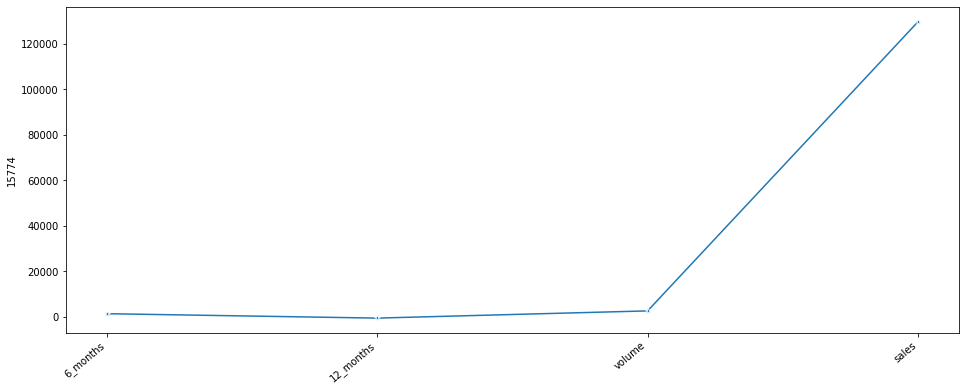

In [115]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t[15774],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

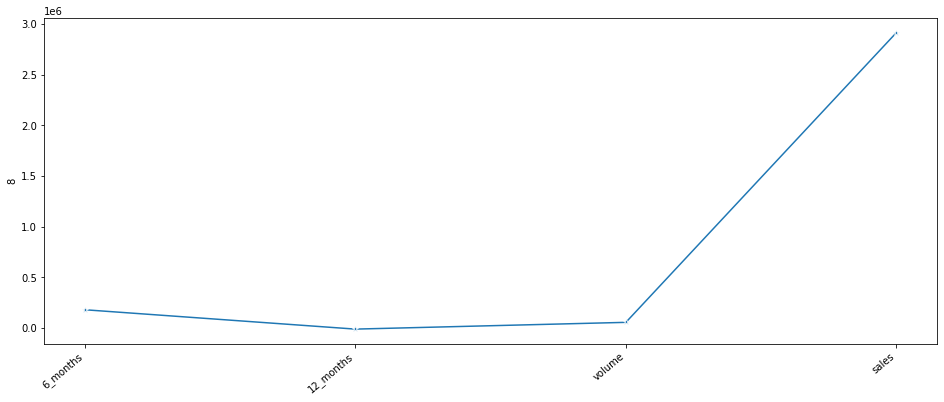

In [116]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t[8],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

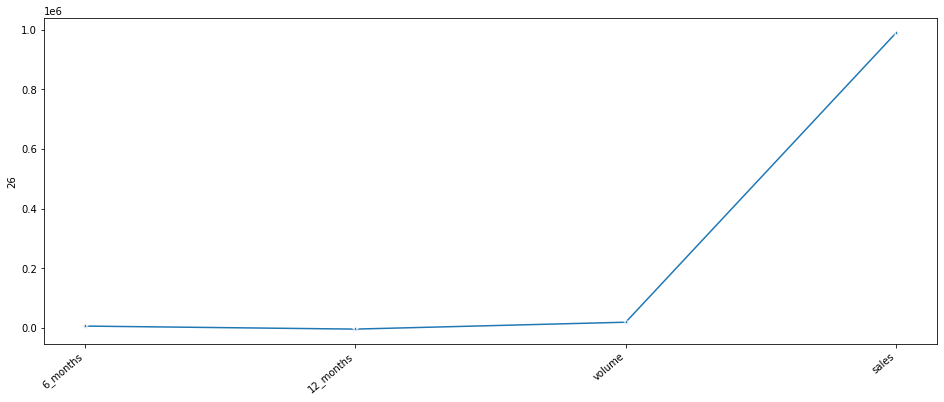

In [117]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t[26],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

Cluster 1 = Saturation

In [118]:
t1 = features[features['label'] == 1].iloc[:, :-1].T

In [119]:
t1

,6,10,12,19,24,25,29,32,34,39,...,15768,15770,15771,15772,15773,15775,15779,15784,15785,15789
6_months,-2106.100000,-141.000,-2777.200000,-2274.100000,-306.000000,-1.174890e+04,-13995.800,-732.300000,-5.742800e+03,-574.900000,...,-1017.500000,-696.800000,-2319.300000,-2677.100000,-1419.700000,-11999.600000,-4098.600000,-1794.300000,-2939.700000,-988.800000
12_months,-1701.100000,-1145.000,-5085.200000,-1376.100000,-1890.000000,-1.025490e+04,-5624.800,-1760.300000,-8.891800e+03,-1281.900000,...,-2881.500000,-1615.800000,-2440.300000,-3335.100000,-1554.700000,-8149.600000,-1865.600000,-981.300000,-4210.700000,-4052.800000
volume,3692.309615,2950.175,5061.613462,3716.857692,13312.307692,3.624536e+04,22156.275,2250.784615,3.021669e+04,13370.138462,...,8175.244231,7567.282692,3619.905769,3141.882692,3332.917308,16685.644231,9550.684615,3617.842308,8838.826923,8893.501923
sales,192000.100000,153409.100,263203.900000,193276.600000,692240.000000,1.884759e+06,1152126.300,117040.800000,1.571268e+06,695247.200000,...,425112.700000,393498.700000,188235.100000,163377.900000,173311.700000,867653.500000,496635.600000,188127.800000,459619.000000,462462.100000


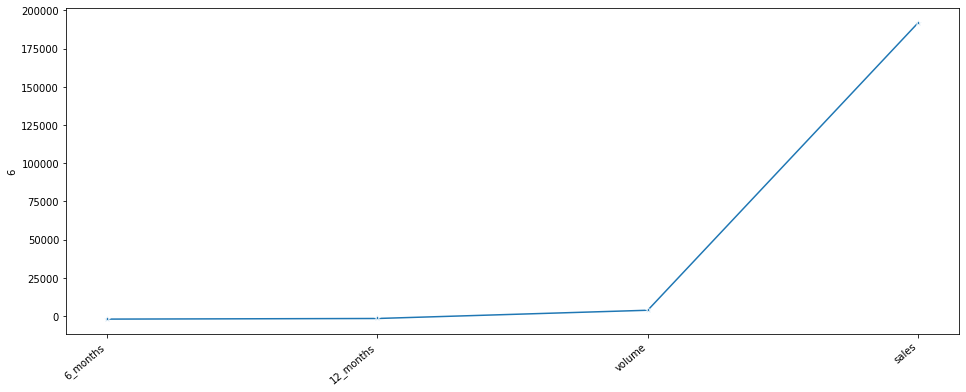

In [120]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t1[6],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

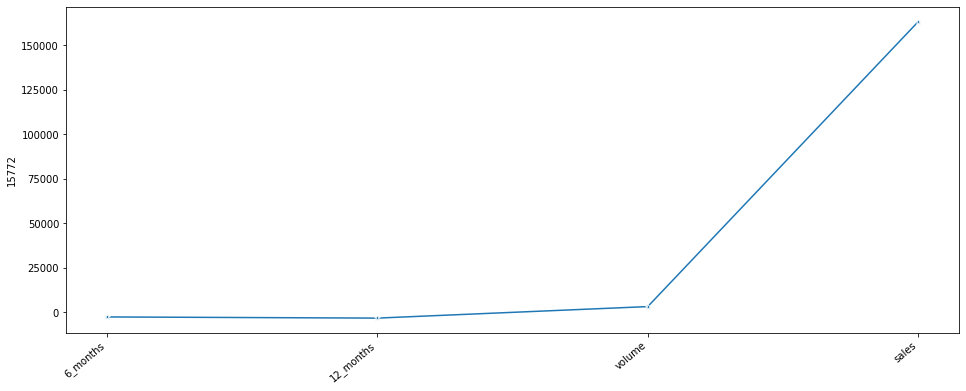

In [121]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t1[15772],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

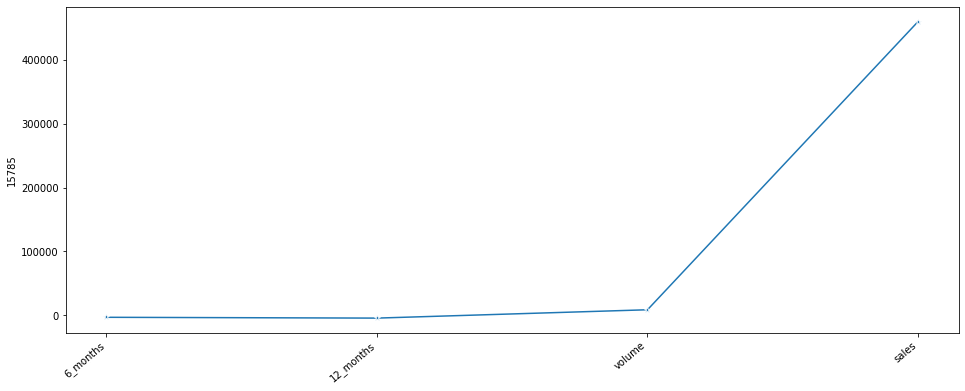

In [122]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t1[15785],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [123]:
t2 = features[features['label'] == 2].iloc[:, :-1].T

In [124]:
t2

,0,1,2,5,7,9,17,18,22,23,...,15740,15741,15749,15756,15757,15758,15761,15778,15782,15788
6_months,-5.609640e+04,-7310.900000,-2818.000000,-1.202900e+04,-2267.00,-3586.200000,-3.559500e+03,-968.000000,-8.118500e+03,-8768.100000,...,212.300000,-280.000000,-556.700000,-1514.800000,-228.600000,353.300000,-1.135670e+04,-2827.100000,-316.4,244.600000
12_months,-5.001400e+03,6417.100000,2621.000000,-1.384000e+03,2357.00,2153.800000,1.425250e+04,2458.000000,-3.097500e+03,-524.100000,...,3283.300000,980.000000,288.300000,146.200000,133.400000,503.300000,8.453000e+02,-666.100000,1054.6,3990.600000
volume,2.434155e+04,9617.613462,4775.844231,3.553891e+04,8589.95,9036.917308,4.223404e+04,4535.259615,5.790219e+04,15362.911538,...,14886.407692,3578.707692,3248.832692,4040.121154,2514.655769,3157.686538,2.329263e+04,18052.294231,12345.2,13941.463462
sales,1.265760e+06,500115.900000,248343.900000,1.848023e+06,446677.40,469919.700000,2.196170e+06,235833.500000,3.010914e+06,798871.400000,...,774093.200000,186092.800000,168939.300000,210086.300000,130762.100000,164199.700000,1.211217e+06,938719.300000,641950.4,724956.100000


Cluster 2 = Emerging

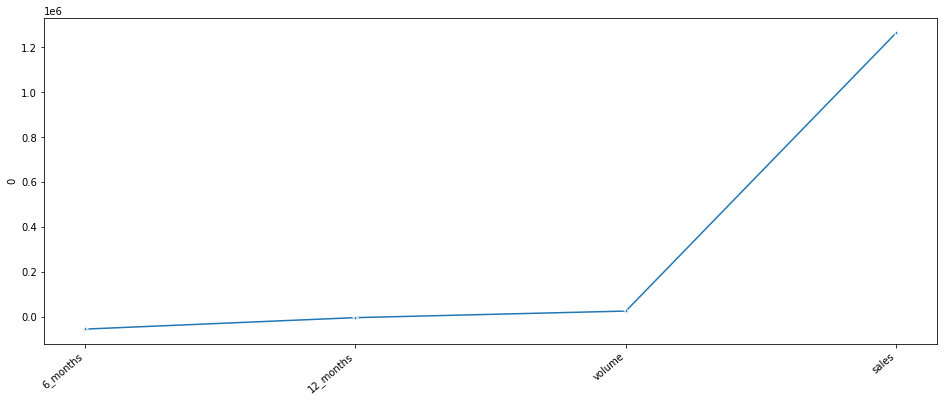

In [125]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t2[0],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

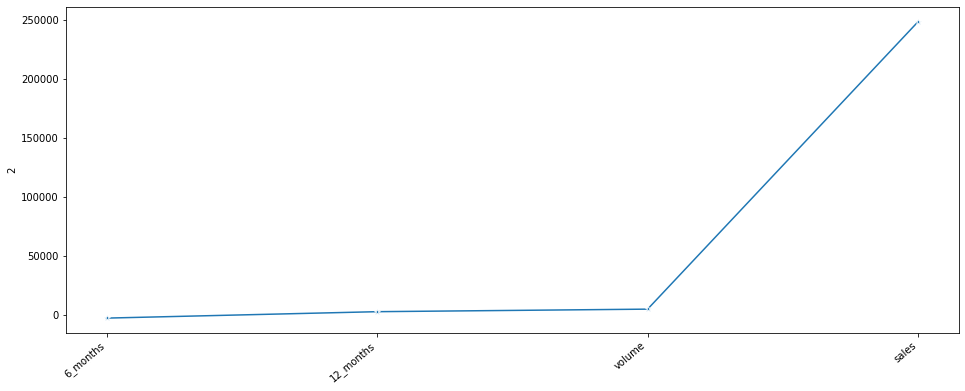

In [126]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t2[2],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

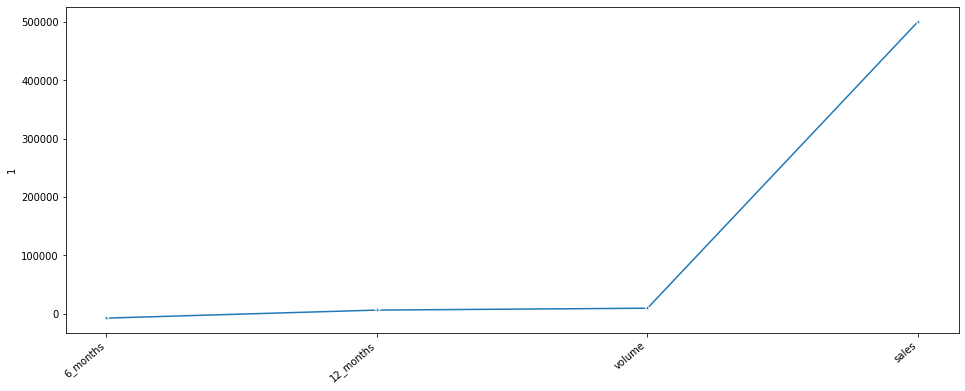

In [127]:
#transposed_input[15765].plot()
fig,ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x=t.index,y=t2[1],marker='*',ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

# Features = 6 months, 1 year growth, mean and overall sales - Agglomerative

In [21]:
sales_data_normalized = normalized_sales_data_df

In [22]:
def get_6_months_growth(df):
    sum = 0
    for i in range(0, 25):
        sum += (df[i+1] - df[i])
    return sum

def get_12_months_growth(df):
    sum = 0
    for i in range(0, 51):
        sum += (df[i+1] - df[i])
    return sum

features = pd.DataFrame()
features['6_months'] = get_6_months_growth(annual_data)
features['12_months'] = get_12_months_growth(annual_data)
features['volume'] = annual_data.mean(axis = 1)
features['sales'] = annual_data.sum(axis = 1)
features.head()

X = features.values
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X.T).T
scaled_df

array([[-0.65569173, -0.56348641, -0.51053454,  1.72971267],
       [-0.62454173, -0.56080655, -0.54594748,  1.73129576],
       [-0.6177914 , -0.5669173 , -0.5467618 ,  1.7314705 ],
       ...,
       [-0.58248819, -0.59671858, -0.55262474,  1.7318315 ],
       [-0.59595118, -0.583919  , -0.55195676,  1.73182694],
       [-0.58856253, -0.60390145, -0.53908999,  1.73155397]])

In [29]:
num_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters)
features['cluster'] = agg_clustering.fit_predict(scaled_df)

In [30]:
features

,6_months,12_months,volume,sales,cluster
0,-56096.4,-5001.4,24341.548077,1265760.5,2
1,-7310.9,6417.1,9617.613462,500115.9,2
2,-2818.0,2621.0,4775.844231,248343.9,2
4,2576.5,-1930.5,9119.890385,474234.3,1
5,-12029.0,-1384.0,35538.911538,1848023.4,0
...,...,...,...,...,...
15785,-2939.7,-4210.7,8838.826923,459619.0,0
15786,596.4,-5833.6,18856.655769,980546.1,0
15787,2281.9,106.9,6846.286538,356006.9,1
15788,244.6,3990.6,13941.463462,724956.1,0


In [101]:
features['cluster'].value_counts()

cluster
0    9683
1    4646
2    1105
Name: count, dtype: int64

In [35]:
t = features[features['cluster'] == 0].iloc[:, :-1].T

In [36]:
t

,5,6,10,12,19,21,22,23,24,25,...,15778,15779,15780,15782,15783,15784,15785,15786,15788,15789
6_months,-1.202900e+04,-2106.100000,-141.000,-2777.200000,-2274.100000,3035.500000,-8.118500e+03,-8768.100000,-306.000000,-1.174890e+04,...,-2827.100000,-4098.600000,135.300000,-316.4,6.776400e+03,-1794.300000,-2939.700000,596.400000,244.600000,-988.800000
12_months,-1.384000e+03,-1701.100000,-1145.000,-5085.200000,-1376.100000,-1065.500000,-3.097500e+03,-524.100000,-1890.000000,-1.025490e+04,...,-666.100000,-1865.600000,-1838.700000,1054.6,-2.448600e+03,-981.300000,-4210.700000,-5833.600000,3990.600000,-4052.800000
volume,3.553891e+04,3692.309615,2950.175,5061.613462,3716.857692,18916.811538,5.790219e+04,15362.911538,13312.307692,3.624536e+04,...,18052.294231,9550.684615,14170.980769,12345.2,7.560553e+04,3617.842308,8838.826923,18856.655769,13941.463462,8893.501923
sales,1.848023e+06,192000.100000,153409.100,263203.900000,193276.600000,983674.200000,3.010914e+06,798871.400000,692240.000000,1.884759e+06,...,938719.300000,496635.600000,736891.000000,641950.4,3.931488e+06,188127.800000,459619.000000,980546.100000,724956.100000,462462.100000


In [89]:
def print_plot(search_term):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=t.index[:-1], y=search_term[:-1], marker='*', ax=ax)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()

Saturation

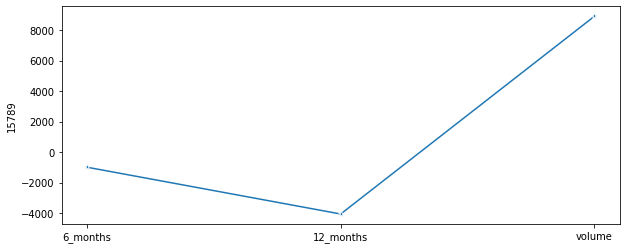

In [90]:
print_plot(t[15789])

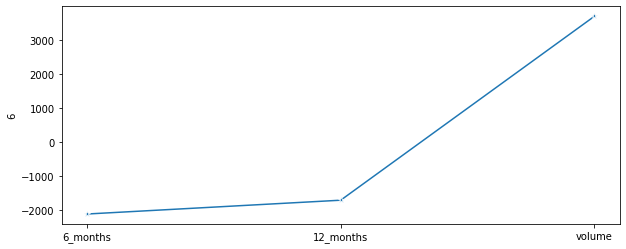

In [91]:
print_plot(t[6])

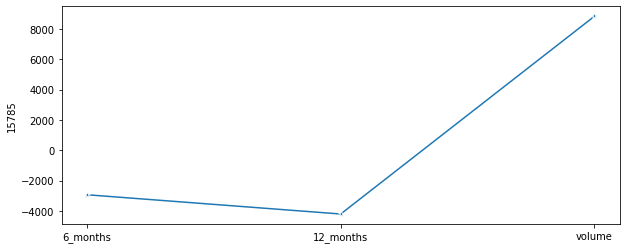

In [92]:
print_plot(t[15785])

In [93]:
t1 = features[features['cluster'] == 1].iloc[:, :-1].T

In [94]:
t1

,4,8,11,13,14,15,16,20,26,35,...,15747,15748,15752,15754,15767,15769,15774,15776,15781,15787
6_months,2576.500000,1.802294e+05,7445.000000,1.672760e+04,423.300,1938.600000,9.899600e+03,6.279100e+03,6078.100000,8.943680e+04,...,2939.000000,3733.500000,3194.800000,517.800000,2.235290e+04,1167.600000,1258.300000,481.600000,1909.200000,2281.900000
12_months,-1930.500000,-1.061160e+04,2195.000000,-3.820400e+03,-1458.700,637.600000,-8.344400e+03,-1.046900e+03,-4068.900000,-4.360220e+04,...,247.000000,1512.500000,425.800000,-1835.200000,-1.987810e+04,368.600000,-680.700000,-1018.400000,-697.800000,106.900000
volume,9119.890385,5.603269e+04,16608.753846,4.229321e+04,3815.025,3792.305769,2.910838e+04,2.208654e+04,19032.215385,2.337848e+05,...,5151.538462,5497.980769,7028.651923,6832.923077,1.219980e+05,3597.061538,2494.530769,4533.265385,3825.001923,6846.286538
sales,474234.300000,2.913700e+06,863655.200000,2.199247e+06,198381.300,197199.900000,1.513636e+06,1.148500e+06,989675.200000,1.215681e+07,...,267880.000000,285895.000000,365489.900000,355312.000000,6.343896e+06,187047.200000,129715.600000,235729.800000,198900.100000,356006.900000


Declining

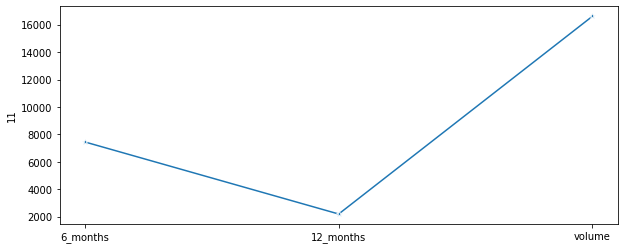

In [97]:
print_plot(t1[11])

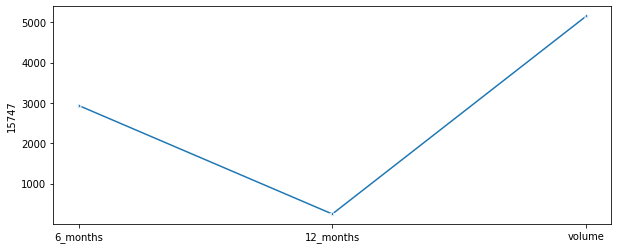

In [96]:
print_plot(t1[15747])

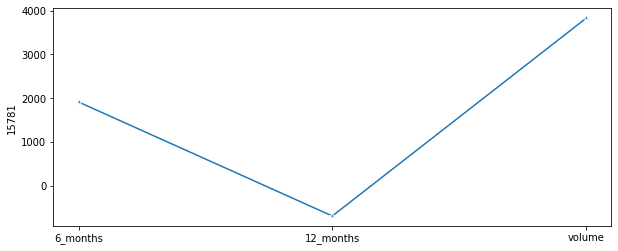

In [95]:
print_plot(t1[15781])

In [45]:
t2 = features[features['cluster'] == 2].iloc[:, :-1].T

In [46]:
t2

,0,1,2,7,9,17,18,28,30,37,...,15646,15658,15666,15673,15676,15691,15715,15740,15741,15749
6_months,-5.609640e+04,-7310.900000,-2818.000000,-2267.00,-3586.200000,-3.559500e+03,-968.000000,2171.700000,-1749.200000,-1334.300000,...,-1487.800000,-8.243900e+03,-589.700000,-10728.600000,-7.464500e+03,-3779.500000,-103.200000,212.300000,-280.000000,-556.700000
12_months,-5.001400e+03,6417.100000,2621.000000,2357.00,2153.800000,1.425250e+04,2458.000000,12584.700000,616.800000,1718.700000,...,710.200000,9.393100e+03,2006.300000,1718.400000,1.784500e+03,5190.500000,711.800000,3283.300000,980.000000,288.300000
volume,2.434155e+04,9617.613462,4775.844231,8589.95,9036.917308,4.223404e+04,4535.259615,14701.990385,3672.294231,7492.361538,...,3256.067308,3.504601e+04,2861.226923,15863.636538,2.836642e+04,10100.530769,3636.311538,14886.407692,3578.707692,3248.832692
sales,1.265760e+06,500115.900000,248343.900000,446677.40,469919.700000,2.196170e+06,235833.500000,764503.500000,190959.300000,389602.800000,...,169315.500000,1.822393e+06,148783.800000,824909.100000,1.475054e+06,525227.600000,189088.200000,774093.200000,186092.800000,168939.300000


Emerging

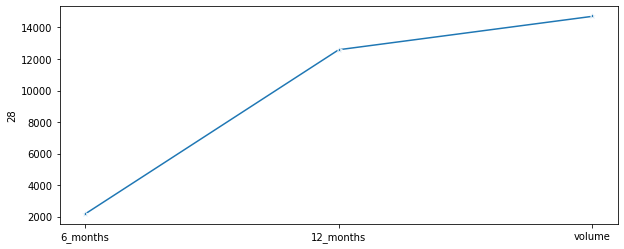

In [98]:
print_plot(t2[28])

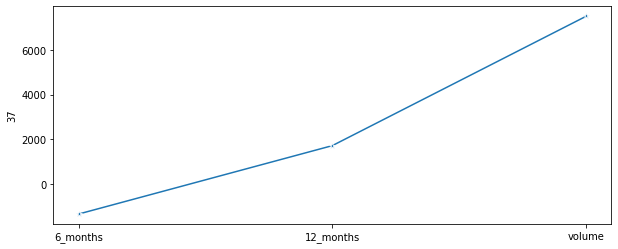

In [99]:
print_plot(t2[37])

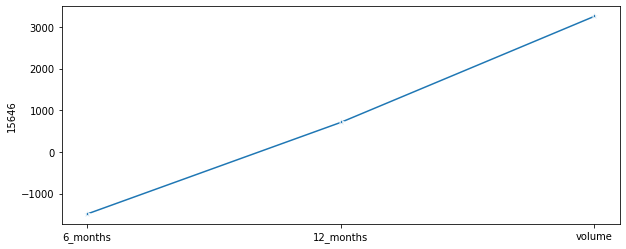

In [100]:
print_plot(t2[15646])